In [134]:
import numpy as np
import IPython.display as ipd
import librosa

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

%pylab inline

Populating the interactive namespace from numpy and matplotlib


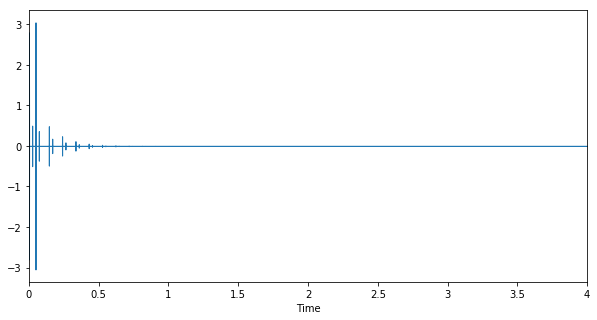

In [189]:
class delayline:
    def __init__(self, M):
        self.M = M;
        self.D = np.zeros(M);
        self.ptr = 0;
        self.current_state = 0;
    def update_delayline(self, x):
        self.current_state = self.D[self.ptr]
        self.D[self.ptr] = x;
        self.ptr += 1;
        if self.ptr >= M:
            self.ptr -= M;
        self.ptr %= M;
    
class feedforward_combfilter:
    def __init__(self, M, b0, bM):
        self.M = M;
        self.b0 = b0;
        self.bM = bM;
        self.dl = delayline(M);
    
    def update(self, x):
        self.dl.update_delayline(x);
        y = self.b0*x + self.bM*self.dl.current_state;
        return y
    
class feedback_combfilter:
    def __init__(self, M, b0, aM):
        self.M = M;
        self.b0 = b0;
        self.aM = aM;
        self.D = np.zeros(M);
        self.ptr = 0;
        
    def update(self, x):
        yM = self.D[self.ptr];
        y = self.b0*x + self.aM*yM;
        self.D[self.ptr] = y;
        self.ptr += 1;
        if self.ptr >= self.M:
            self.ptr -= self.M;
        self.ptr %= self.M;
        
        return y
    
class allpass:
    def __init__(self, M, b0, aM):
        self.M = M;
        self.b0 = b0;
        self.aM = aM;
        self.xD = np.zeros(M);
        self.yD = np.zeros(M);
        self.xptr = 0;
        self.yptr = 0;
        
    def update(self, x):
        xM = self.xD[self.xptr];
        self.xD[self.xptr] = x;
        self.xptr += 1;
        if self.xptr >= M:
            self.xptr -= M;
        self.xptr %= M;
        yM = self.yD[self.yptr];
        y = self.b0*x + xM - self.aM*yM;
        self.yD[self.yptr] = y;
        self.yptr += 1;
        if self.yptr >= self.M:
            self.yptr -= self.M;
        self.yptr %= self.M;
        return y

class schroeder1:
    def __init__(self, ap1, ap2, ap3, ffcf1, ffcf2, ffcf3, ffcf4):
        self.ap1 = ap1;
        self.ap2 = ap2;
        self.ap3 = ap3;
        self.ffcf1 = ffcf1;
        self.ffcf2 = ffcf2;
        self.ffcf3 = ffcf3;
        self.ffcf4 = ffcf4;
    def update(self, x):
        tmp = self.ap1.update(x);
#         y = self.ap3.update(self.ap2.update(self.ap1.update(x)));
        y = self.ffcf1.update(tmp) + self.ffcf3.update(tmp) + self.ffcf3.update(tmp) + self.ffcf4.update(tmp);
        return y;

# M-sample delay
# M = 1051;
# dl = delayline(M);

# # Feed-forward comb filter for acoustic echo simulation
# b0 = 1;
# bM = 0.8;
# aM = .5;
# ffcf = feedforward_combfilter(M, b0, bM);
# fbcf = feedback_combfilter(M, b0, aM);
# ap = allpass(M, .8, .8);

ap1 = allpass(1051, .7, .7);
ap2 = allpass(337, .7, .7);
ap3 = allpass(113, .7, .7);

ffcf1 = feedforward_combfilter(4799, 1, 0.742);
ffcf2 = feedforward_combfilter(4999, 1, 0.733);
ffcf3 = feedforward_combfilter(5399, 1, 0.715);
ffcf4 = feedforward_combfilter(5801, 1, 0.697);

sch_rvb1 = schroeder1(ap1, ap2, ap3, ffcf1, ffcf2, ffcf3, ffcf4);
# Relative gain factor
g = 0.8

    
Fs = 44100
Ts = 1/Fs
t = np.arange(0, 2, Ts)
f1 = 350
f2 = 440
#x = (np.sin(2*pi*f1*t) + np.sin(2*pi*f2*t))
x = np.zeros(len(t))
x[0] = 1

# x, sr = librosa.load('audio/SNARE_01_01.WAV')
# x, sr = librosa.load('audio/C strum chord_mono.wav')
y = np.full_like(x, 0)
L = len(x)

for n in range(0, L-1):
    y[n] = sch_rvb1.update(x[n]);

plt.figure(figsize=(10, 5))
librosa.display.waveplot(y, sr=sr)

ipd.Audio(y, rate=sr)